In [1]:
%load_ext autoreload
%autoreload 2
%cd ../

/home/projects/schneidmann/royu/thesis/unsup_neur


In [2]:
from utils.modules import Modules
from run_before_script import run
run()

In [3]:
from vision.utils.figures_utils import EXTENDED_QS, EXTENDED_QS_LABELS
from vision.evaluate import EVAL_ENS_LIN, EVAL_IND_LIN, EVAL_ENS_LIN_NAME, EVAL_IND_LIN_NAME
from utils.figure_utils import gather_results_over_all_args
from utils.figure_utils import plot_lines_different_along_q as plot_along_q
from utils.utils import get_min_max
from utils.plot_utils import *
from matplotlib import pyplot as plt
from utils.measures.utils import CrossPathMeasures
from utils.utils import paired_t_test, ind_t_test, paired_permutation_test, ind_permutation_test
import numpy as np
import os

In [4]:
REPO = False   # Change to True

q_index = 2
chosen_q = EXTENDED_QS[q_index]

SEEDS = np.arange(1, 11)
N = 10
NS = np.array([2,3,5,10,15])


model_basic_format = "vit_lite_2_4_N{N}_d{d}_seed{seed}" if REPO else "vit_lite_2_4_paths_{N}_d{d}_seed{seed}"
ending = "" if REPO else "_encperpath_patchperpath"
model_format = model_basic_format.format(N=N, d="{d}", seed="{seed}") + ending
model_format_N = model_basic_format + ending
model_format_N_closer = model_format_N + ("" if REPO else "_noreg")
model_format_untrained = model_format + "_untrained"
model_format_closer = model_format + ("" if REPO else "_noreg")
model_format_sup = model_format + ("_supervised" if REPO else "_pathsup")

task_ind = EVAL_IND_LIN
task_ind_imgs = "image_" + task_ind
task_ens = EVAL_ENS_LIN

SINGLE_ENCODER_TITLE = "Single encoder"
ENSEMBLE_TITLE = "Ensemble"
font_size = 12

In [5]:
full_img_baseline = Modules.VISION.load_evaluation_json((model_basic_format + ending).format(N=1, d=1, seed=1) + "_untrained")[task_ind_imgs][-1]

In [6]:
SAVE = True

FIGURES_DIR = 'figures/'
os.makedirs(FIGURES_DIR, exist_ok=True)
def savefig(fn, fignum=None):
    if SAVE:
        from utils.plot_utils import savefig as orig_savefig
        cur_path = os.path.join(*([FIGURES_DIR] + ([str(fignum)] if fignum is not None else []) + [fn]))
        os.makedirs(os.path.join(*cur_path.split("/")[:-1]), exist_ok=True)
        orig_savefig(cur_path)

# Figure 2

## Figure 2a

In [7]:
from cls_likelihood import calculate_class_mean_likelihood

In [8]:
class NameWrapper:
    def __init__(self, name):
        self.name = name

In [9]:
model_name_base = "vit_lite_2_4_paths_10_d{d}_seed{seed}_encperpath_patchperpath"
inp = False

In [10]:
from vision.utils.data import Cifar10
labels = Cifar10.LABELS
ordering = np.array([1, 9, 8, 0, 2, 4, 6, 3, 5, 7])

In [11]:
def plot_cls_mean_like(models, titles, inps, n_paths=10, size=10, cmaps='Reds', normalize=False, save=True):
    if isinstance(cmaps, str):
        cmaps = [cmaps]*len(models)
    arrs = np.stack([calculate_class_mean_likelihood(NameWrapper(model_name), Modules.VISION, inp=inp) for model_name, inp in zip(models, inps)], axis=0)
    if normalize:
        arrs = arrs / arrs.sum(axis=2, keepdims=True)
    for p in range(n_paths):
        vmin, vmax = get_min_max(arrs[..., p])
        fig, axs = plt.subplots(1, len(models), figsize=(4*len(models), 4))
        for i in range(len(models)):
            ax = axs[i] if len(models) > 1 else axs
            colorbar(ax.imshow(arrs[i][ordering][:, ordering][..., p], origin='lower', cmap=cmaps[i], vmin=vmin, vmax=vmax)).set_label(r"$\langle$conditional pseduo-likelihood$\rangle$", 
                                                                                                                                       size=size*1.2)
            ax.set_xticks(np.arange(len(labels)), labels[ordering], rotation=45, size=size, ha='right')
            ax.set_yticks(np.arange(len(labels)), labels[ordering], size=size)
            ax.set_title(titles[i], size=size*1.5)
        plt.tight_layout()

        if save: savefig(f"cls_like/encoder{p}", 2)
        if not p:
            savefig("a", 2)
            plt.show()
        else:
            plt.close()

saved figure as figures/2/cls_like/encoder0.png
saved figure as figures/2/a.png


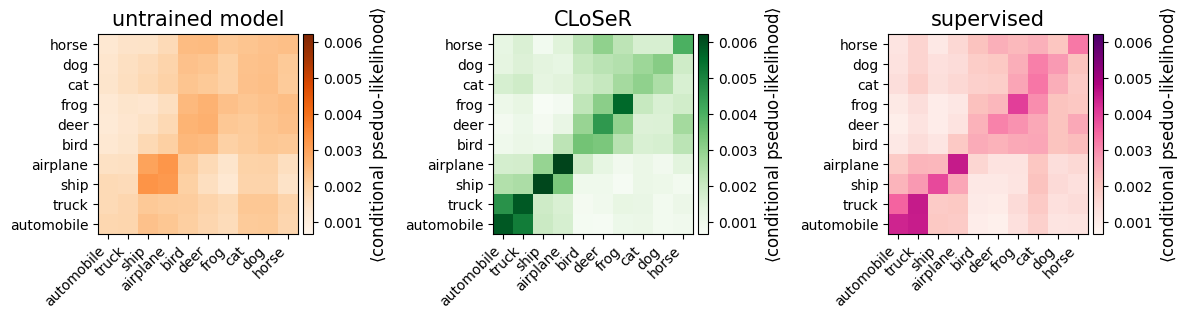

saved figure as figures/2/cls_like/encoder1.png
saved figure as figures/2/cls_like/encoder2.png
saved figure as figures/2/cls_like/encoder3.png
saved figure as figures/2/cls_like/encoder4.png
saved figure as figures/2/cls_like/encoder5.png
saved figure as figures/2/cls_like/encoder6.png
saved figure as figures/2/cls_like/encoder7.png
saved figure as figures/2/cls_like/encoder8.png
saved figure as figures/2/cls_like/encoder9.png


In [12]:
seed = 3
plot_cls_mean_like([
    model_name_base.format(seed=seed, d=EXTENDED_QS[q_index]) + "_untrained", 
    model_name_base.format(seed=seed, d=EXTENDED_QS[q_index]) + "_noreg",
    model_name_base.format(seed=seed, d=EXTENDED_QS[q_index]) + "_pathsup"
                   ], 
    [
        NamesAndColors.UNTRAINED.value.name, 
        NamesAndColors.UNSUPERVISED.value.name,
        NamesAndColors.SUPERVISED.value.name
    ],
    [
        False, 
        False, 
        False
    ], 
    n_paths=10, size=10, 
    cmaps=[
        "Oranges", 
        "Greens", 
        "RdPu"
    ], 
    normalize=False, save=True)

## Figure 2b

In [13]:
def gather_all_paths(m_format, inp=False, single=True, print_missing=True):
    arr = np.stack([gather_results_over_all_args(m_format, {"d": np.array(EXTENDED_QS)}, 
                                                 module=Modules.VISION, seeds=SEEDS, 
                                                 name="image_"*inp + (f'pathway{i}_linear' if single else EVAL_ENS_LIN), 
                                                 print_missing=print_missing)
                    for i in range(N if single else 1)], axis=-2)[..., -1]
    if not single: arr = arr[..., 0]
    return arr

In [14]:
dct_all_paths = {
    NamesAndColors.MASKED.value: gather_all_paths(model_format_untrained, inp=True),
    NamesAndColors.UNTRAINED.value: gather_all_paths(model_format_untrained),
    NamesAndColors.UNSUPERVISED.value: gather_all_paths(model_format_closer),
    NamesAndColors.SUPERVISED.value: gather_all_paths(model_format_sup),
}

saved figure as figures/2/b.png


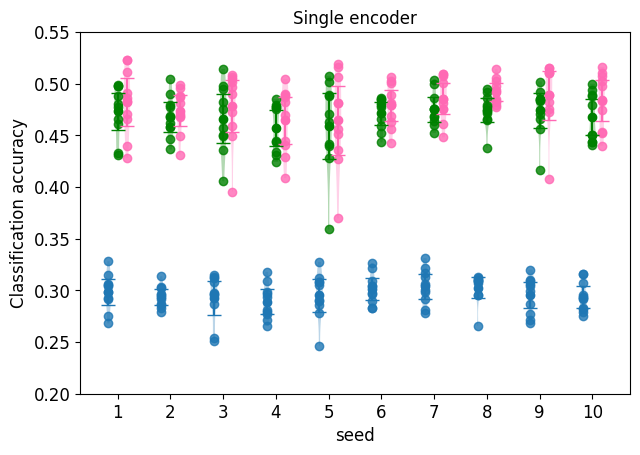

In [15]:
width = 4
capsize = 5
height = 4.5

fig, ax = plt.subplots(figsize=(6.5,height))
common_kwargs = dict(scatter=True, box=False, sem=False, ax=ax, fig=fig, capsize=capsize)

dct_to_multiviolin({i+1: arr for i, arr in enumerate(dct_all_paths[NamesAndColors.MASKED.value][q_index].T)}, 
                   xs=(SEEDS - 0.175)*width,
                    c=NamesAndColors.MASKED.value.color,
                   **common_kwargs
                  )

dct_to_multiviolin({i+1: arr for i, arr in enumerate(dct_all_paths[NamesAndColors.SUPERVISED.value][q_index].T)}, 
                   xs=(SEEDS + 0.175)*width,
                   c=NamesAndColors.SUPERVISED.value.color, 
                   **common_kwargs
                  )

dct_to_multiviolin({i+1: arr for i, arr in enumerate(dct_all_paths[NamesAndColors.UNSUPERVISED.value][q_index].T)}, 
                   xs=SEEDS*width,
                   c=NamesAndColors.UNSUPERVISED.value.color,
                   **common_kwargs
                  )

plt.xlabel("seed", size=font_size)
YLABEL_CLASS_F(ax=ax)
plt.ylabel(ax.get_ylabel(), size=font_size)
plt.xlabel(ax.get_xlabel(), size=font_size)
plt.xticks(plt.xticks()[0], plt.xticks()[1], size=font_size)
plt.yticks(plt.yticks()[0], plt.yticks()[1], size=font_size)
plt.tight_layout()
plt.title(SINGLE_ENCODER_TITLE, size=font_size)
xlims, ylims = plt.xlim(), plt.ylim()
savefig("b", 2)

## Figure 2c

In [16]:
dct_ensemble = {
    NamesAndColors.UNTRAINED.value: gather_all_paths(model_format_untrained, single=False),
    NamesAndColors.UNSUPERVISED.value: gather_all_paths(model_format_closer, single=False),
    NamesAndColors.SUPERVISED.value: gather_all_paths(model_format_sup, single=False),
}

saved figure as figures/2/c.png


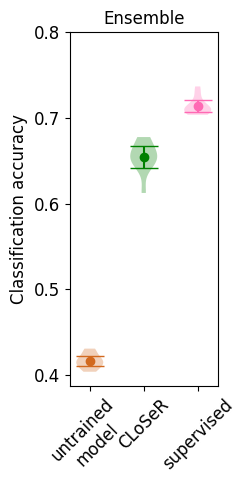

In [17]:
fig, ax = plt.subplots(1, figsize=(2.5,height + 0.5))
plt.title(ENSEMBLE_TITLE, size=font_size)
dct_to_multiviolin({'\n'.join(k.name.split()): v[q_index] for k, v in dct_ensemble.items()}, 
                   c={'\n'.join(k.name.split()): k.color for k, v in dct_ensemble.items()},
                   ax=ax, rotation=45)
YLABEL_CLASS_F(ax=ax, size=font_size)
plt.xticks(plt.xticks()[0], plt.xticks()[1], size=font_size)
plt.yticks(np.arange(0.4, 0.81, 0.1).round(1), np.arange(0.4, 0.81, 0.1).round(1), size=font_size)
plt.tight_layout()
savefig("c", 2)

## Figure 2d

In [18]:
from utils.plot_utils import plot_with_CI
common_kwargs = dict(module=Modules.VISION, args={}, seeds=SEEDS, print_missing=True)

unsupervised_results_N = np.stack([gather_results_over_all_args(model_format_N.format(d=EXTENDED_QS[q_index], seed='{seed}', N=n), 
                                                                name=task_ind, **common_kwargs) for n in NS])

supervised_results_N = np.stack([gather_results_over_all_args(model_format_N.format(d=EXTENDED_QS[q_index], seed='{seed}', N=N) + "_pathsup", 
                                                              name=task_ind, **common_kwargs)] * len(NS))

untrained_results_N = np.stack([gather_results_over_all_args(model_format_N.format(d=EXTENDED_QS[q_index], seed='{seed}', N=N) + "_untrained", 
                                                             name=task_ind, **common_kwargs)] * len(NS))

img_results_N = np.stack([gather_results_over_all_args(model_format_N.format(d=EXTENDED_QS[q_index], seed='{seed}', N=N) + "_untrained", 
                                                       name=task_ind_imgs, **common_kwargs)] * len(NS))


saved figure as figures/2/d.png


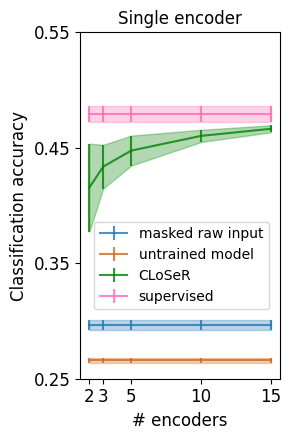

In [19]:
fig, ax = plt.subplots(figsize=(3,height))

plot_with_CI(img_results_N[..., -1], NS, axis=-1, label=NamesAndColors.MASKED.value.name, c=NamesAndColors.MASKED.value.c)
plot_with_CI(untrained_results_N[..., -1], NS, axis=-1, label=NamesAndColors.UNTRAINED.value.name, c=NamesAndColors.UNTRAINED.value.c)
plot_with_CI(unsupervised_results_N[..., -1], NS, axis=-1, label=NamesAndColors.UNSUPERVISED.value.name, c=NamesAndColors.UNSUPERVISED.value.c)
plot_with_CI(supervised_results_N[..., -1], NS, axis=-1, label=NamesAndColors.SUPERVISED.value.name, c=NamesAndColors.SUPERVISED.value.c)

plt.xlabel("# encoders", size=font_size)
YLABEL_CLASS_F()
yticks = plt.yticks()
plt.yticks(np.linspace(0.25, 0.55, 4), size=font_size)
plt.xticks(NS, NS, size=font_size)
plt.ylabel(ax.get_ylabel(), size=font_size)
plt.title(SINGLE_ENCODER_TITLE, size=font_size)
plt.tight_layout()
plt.legend(loc=(.07, .2))
plt.ylim(0.25, 0.55)
savefig("d", 2)

# Figure 3

In [20]:
names_and_colors = [NamesAndColors.MASKED, NamesAndColors.UNTRAINED, NamesAndColors.UNSUPERVISED, NamesAndColors.SUPERVISED]
names_and_colors = [enum.value for enum in names_and_colors]

## Figure 3a

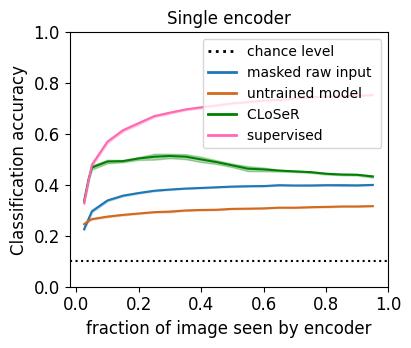

saved figure as figures/3/a.png


In [21]:
from matplotlib import rcParams
for legend in (True, False):
    fig, ax = plt.subplots(figsize=(4,3.5)) 
    plt.title(SINGLE_ENCODER_TITLE, size=font_size)
    ax.axhline(0.1, c=NamesAndColors.CHANCE.value.c, linestyle=':', label=NamesAndColors.CHANCE.value.name)
    plot_along_q(model_format_untrained, module=Modules.VISION, seeds=SEEDS, args=[], qs=EXTENDED_QS, ax=ax,
                       name=task_ind_imgs, fig=fig, legend=NamesAndColors.MASKED.value.name, 
                       c=NamesAndColors.MASKED.value.get_c(), print_missing=True)
    for (name_and_color, name_format) in zip(names_and_colors[1:], 
                                             [model_format_untrained, model_format_closer, model_format_sup]):
        plot_along_q(name_format, module=Modules.VISION, seeds=SEEDS, args=[], 
                     qs=EXTENDED_QS, ax=ax,
                     name=task_ind, fig=fig, legend=name_and_color.get_name(), 
                     c=name_and_color.get_c(), print_missing=True)

    Q_OVER_ACC_F(ax=ax, ticksize=8)
    plt.ylabel(ax.get_ylabel(), size=font_size)
    plt.xlabel(ax.get_xlabel(), size=font_size)

    plt.yticks(*plt.yticks(), size=font_size)
    plt.xticks(np.linspace(0, 1, 6), size=font_size)
    if legend:
        legend_linewidth(ax, 2, loc='upper right')
        plt.show()
    else:
        savefig("a", 3)
        plt.close()

## Figure 3b

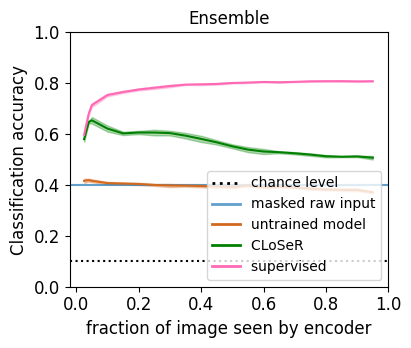

saved figure as figures/3/b.png


In [22]:
for legend in (True, False):
    fig, ax = plt.subplots(figsize=(4,3.5))
    plt.title(ENSEMBLE_TITLE, size=font_size)
    ax.axhline(0.1, c=NamesAndColors.CHANCE.value.c, linestyle=':', label=NamesAndColors.CHANCE.value.name)
    ax.axhline(full_img_baseline, label=NamesAndColors.MASKED.value.name, c=NamesAndColors.FULL_INPUT.value.get_c(), alpha=0.7)
    for i, (name_and_color, name_format) in enumerate(zip(names_and_colors[1:], 
                                                [model_format_untrained, model_format_closer, model_format_sup
                                                ])):
        plot_along_q(name_format, module=Modules.VISION, seeds=SEEDS, args=[], qs=EXTENDED_QS, ax=ax,
                           name=task_ens, fig=fig, legend=name_and_color.get_name(), 
                           c=name_and_color.get_c(), print_missing=True)
    Q_OVER_ACC_F(ax=ax, ticksize=8)
    plt.ylabel(ax.get_ylabel(), size=font_size)
    plt.xlabel(ax.get_xlabel(), size=font_size)
    plt.xticks(np.linspace(0, 1, 6), size=font_size)
    plt.yticks(*plt.yticks(), size=font_size)
    if legend:
        legend_linewidth(ax, loc='lower right')
        plt.show()
    else:
        savefig("b", 3)
        plt.close()

# Supplementary figure 1

## Supplementary figures 1a and 1b

saved figure as figures/s1/a.png


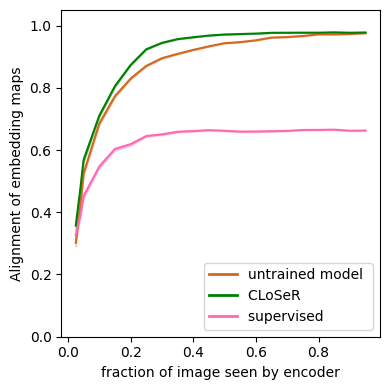

saved figure as figures/s1/b.png


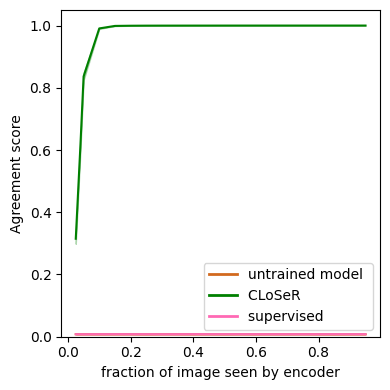

In [23]:

for subfig, measure in enumerate([CrossPathMeasures.Correlation, CrossPathMeasures.Acc, ]):
    for leg in (False, True):
        fig, ax = plt.subplots(figsize=(4,4))
        for nc, cur_model_name in zip((NamesAndColors.UNTRAINED.value, NamesAndColors.UNSUPERVISED.value, NamesAndColors.SUPERVISED.value),
                                      (model_format_untrained, model_format_closer, model_format_sup)):
            plot_along_q(cur_model_name,
                         module=Modules.VISION, 
                         seeds=SEEDS, 
                         args=[], 
                         qs=EXTENDED_QS, 
                         name=measure.name, 
                         measure=True, 
                         fig=fig,
                         ax=ax,
                         legend=nc.name if leg else None, 
                         c=nc.color)

        Q_OVER_ACC_F(ticksize=8)
        plt.ylim(0, 1.05)
        plt.ylabel(measure.value)
        if leg:
            legend_linewidth(ax, loc='lower right')
            plt.show()
        else:
            savefig("a" if subfig==0 else "b", "s1")
            plt.close()

# Supplementary figure 2

In [24]:
common_kwargs = dict(module=Modules.VISION, seeds=SEEDS, args=dict(d=EXTENDED_QS), measure=False, print_missing=True)

diff_arr_closer = np.diff(np.stack([gather_results_over_all_args(model_format_closer.format(d='{d}', seed='{seed}'), 
                                                          **common_kwargs, name=task, ) 
                             for task in [task_ind, task_ens]], axis=-1), axis=-1)[..., -1, 0]

diff_arr_untrained = np.diff(np.stack([gather_results_over_all_args(model_format_untrained.format(d='{d}', seed='{seed}'), 
                                                          **common_kwargs, name=task, ) 
                             for task in [task_ind, task_ens]], axis=-1), axis=-1)[..., -1, 0]

diff_arr_supervised = np.diff(np.stack([gather_results_over_all_args(model_format_sup.format(d='{d}', seed='{seed}'), 
                                                          **common_kwargs, name=task, ) 
                             for task in [task_ind, task_ens]], axis=-1), axis=-1)[..., -1, 0]

saved figure as figures/s2/a.png


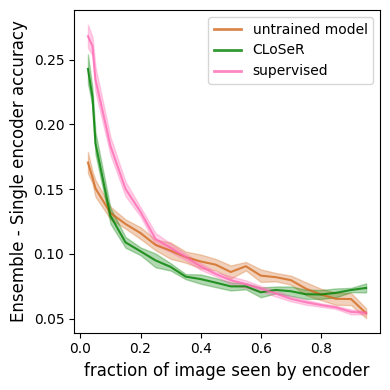

In [25]:
from utils.plot_utils import plot_with_CI
fig, ax = plt.subplots(figsize=(4,4))
plot_with_CI(diff_arr_untrained, np.array(EXTENDED_QS), axis=1, err=False,
             c=NamesAndColors.UNTRAINED.value.c, label=NamesAndColors.UNTRAINED.value.name)
plot_with_CI(diff_arr_closer, np.array(EXTENDED_QS), axis=1, err=False, 
             c=NamesAndColors.UNSUPERVISED.value.c, label=NamesAndColors.UNSUPERVISED.value.name)
plot_with_CI(diff_arr_supervised, np.array(EXTENDED_QS), axis=1, err=False, 
             c=NamesAndColors.SUPERVISED.value.c, label=NamesAndColors.SUPERVISED.value.name)
XLABEL_FRAC_F()
plt.ylabel(f"{EVAL_ENS_LIN_NAME} - {EVAL_IND_LIN_NAME} accuracy")
legend_linewidth(ax)
plt.ylabel(ax.get_ylabel(), size=font_size)
plt.xlabel(ax.get_xlabel(), size=font_size)
plt.tight_layout()
savefig("a", "s2")

# Figure 4

In [26]:
from vision.model.losses import CLoSeRLoss, CirculantGraphLoss, NumEdgesGraphLoss, StarGraphLoss

class GraphFeatures:
    def __init__(self, graph, name, color, name_format='', pos=None):
        self.graph = graph
        self.name = name
        self.color = color
        self.c = color
        self.noint_c, self.int_c = color
        self.name_format = name_format
        self.pos = pos
        self.density = self.graph.get_graph().astype(bool)[~np.eye(self.graph.get_graph().shape[0]).astype(bool)].mean()
        self.intra_mask = self.graph.get_graph().astype(bool)
        self.extra_mask = ~self.graph.get_graph().astype(bool) & ~np.eye(self.graph.get_graph().shape[0]).astype(bool)
    
    def plot(self, title=True, text_size=10, cbar=False, ax=None, **kwargs):
        if ax is None:
            fig, ax = plt.subplot(111)
        self.graph.plot_pull(interaction_c=self.int_c, nointeraction_c=self.noint_c, text_size=text_size, cbar=cbar, ax=ax, **kwargs)
        ax.set_xticks([])
        ax.set_yticks([])
        
    def illustrate(self, multicolor=False, fontsize=10, ax=None, node_size=500, arrowsize=25, width=3,):
        import networkx as nx
        
        G = nx.from_numpy_array(self.graph.get_graph().T, create_using=nx.DiGraph)
        node_colors = self.c # Default to gray if color is missing
        pos = nx.circular_layout(G) if self.pos is None else self.pos
        if ax is None: plt.figure()
        nx.draw(G, pos, with_labels=False, node_color=node_colors[1], edge_color=node_colors[1], 
                node_size=node_size, width=width, font_size=fontsize, arrowstyle='->', arrowsize=arrowsize, ax=ax)
        (ax if ax is not None else plt).axis("equal")

In [27]:
NUMEDGES = np.arange(10, 81, 10)
circular_n = lambda n, shift=0, phase=0: {i+shift: np.array([np.cos(i/n*2*np.pi + phase), np.sin(i/n*2*np.pi + phase)]) for i in range(n)}
pos_star = circular_n(N-1, 1)
pos_star[0] = np.zeros(2)

In [28]:
from enum import Enum
np.random.seed(2)    
class Graph(Enum):
    FULLY_CONNECTED = GraphFeatures(CLoSeRLoss(N), "Fully-connected", [[0]*4, [0, 0.3, 0, 0.6]])
    NUMEDGES = GraphFeatures(NumEdgesGraphLoss(N, num_edges_pull=20), r"$G_N^k$", [[0]*4, [0, 0.5, 0.7, 0.8]])    
    STAR = GraphFeatures(StarGraphLoss(N, 1), "Star structure", [[0]*4, [0.9, 0.1, 0, 0.7]], "star1", pos=pos_star)
    BIRING = GraphFeatures(CirculantGraphLoss(N, 1, symmetric=True), "Bidirectional ring", [[0]*4, [0.5, 0, 0.5, 0.7]], "circular1_symm")
    FORRING = GraphFeatures(CirculantGraphLoss(N, 2), "Directional ring", [[0]*4, [0.9, 0.5, 0, 0.7]], "circular2")

2025-07-22 19:04:02.721861: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-22 19:04:03.075512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:07:00.0, compute capability: 8.6


## Figure 4a

/home/projects/schneidmann/royu/.local/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


saved figure as figures/4/a.png


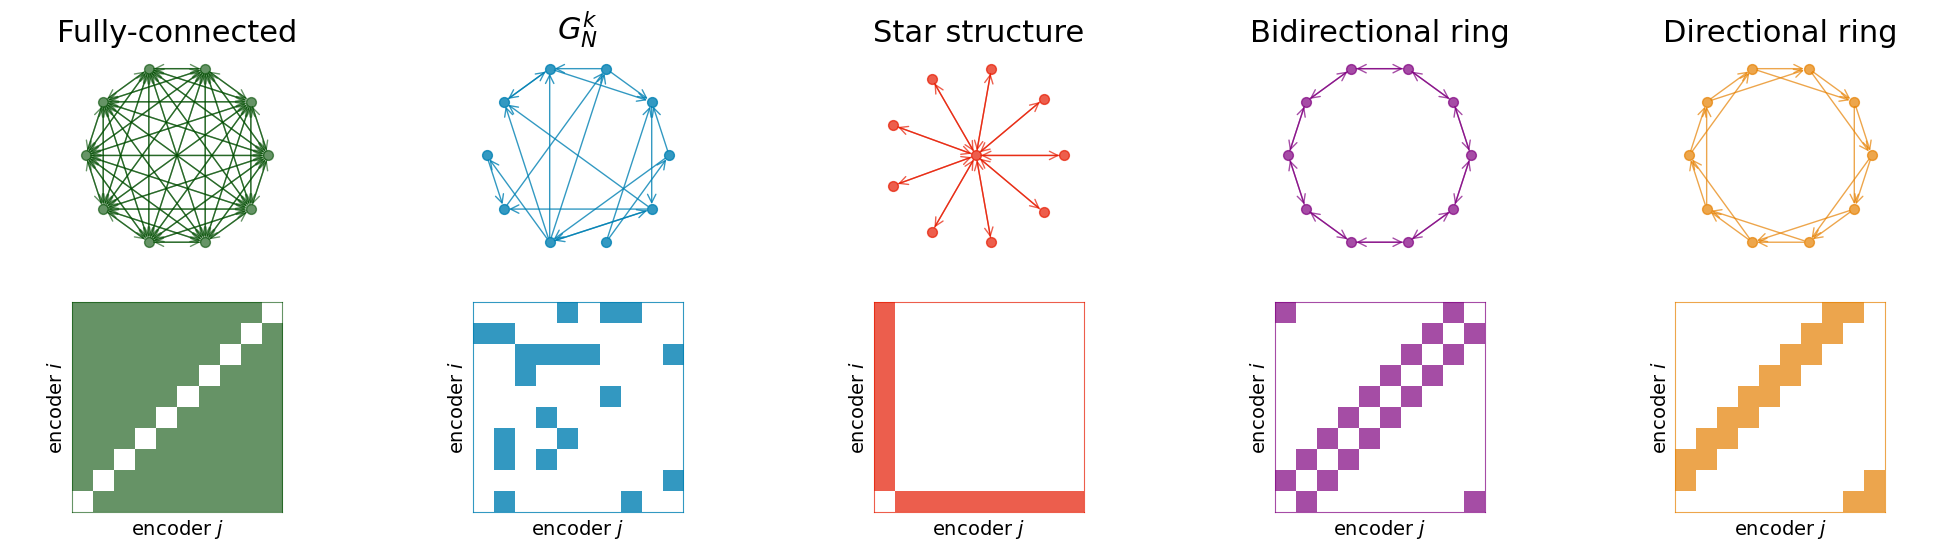

In [29]:
fig, axs = plt.subplots(2, len(Graph), figsize=(len(Graph)*5, 6))
for i, g in enumerate(Graph):
    ax = plt.subplot(2, len(Graph), i+1)
    plt.title(g.value.name, fontsize=22)
    g.value.illustrate(ax=ax, node_size=50, arrowsize=15, width=1)

    ax = plt.subplot(2, len(Graph), len(Graph) + i + 1)
    g.value.plot(ticks=True, cbar=False, labels=True, text_size=14, figsize=(2,2), ax=ax)

savefig("a", 4)

In [30]:
# Plot individuals (and edit afterwards using drawio)
for i, g in enumerate(Graph):
    g.value.illustrate()
    savefig(f"{g.value.name}", "4/a_graphs")
    plt.close()
    
    g.value.plot(ticks=True, cbar=False, labels=True, text_size=14, figsize=(2,2), ax=ax)
    savefig(f"{g.value.name}", "4/a_mats")
    plt.close()

saved figure as figures/4/a_graphs/Fully-connected.png
saved figure as figures/4/a_mats/Fully-connected.png
saved figure as figures/4/a_graphs/$G_N^k$.png
saved figure as figures/4/a_mats/$G_N^k$.png
saved figure as figures/4/a_graphs/Star structure.png
saved figure as figures/4/a_mats/Star structure.png
saved figure as figures/4/a_graphs/Bidirectional ring.png
saved figure as figures/4/a_mats/Bidirectional ring.png
saved figure as figures/4/a_graphs/Directional ring.png
saved figure as figures/4/a_mats/Directional ring.png


## Figure 4b and supplementary figure 3

In [31]:
font_size_graphs = 12
plot_with_CI_kwargs = dict(capsize=2, markersize=7, marker='o', fill_between=False,)
densities = np.array([0] + list(NUMEDGES) + [90]) / 90
XLABEL_INTER_F = lambda ax=None, **kwargs: (ax.set_xlabel if ax else plt.xlabel)("Interaction density", **kwargs)

focus_density = Graph.FORRING.value.density

if REPO:
    basic_graph_format = "vit_lite_2_4_N10_d{d}_seed{{seed}}_{name}"
    numedges_format = "vit_lite_2_4_N10_d{d}_seed{{seed}}_numedges{numedges}"
else:
    basic_graph_format = "vit_lite_2_4_paths_10_d{d}_seed{{seed}}_{name}_encperpath_patchperpath_noreg_sg"
    numedges_format = "vit_lite_2_4_paths_10_d{d}_seed{{seed}}_encperpath_patchperpath_numedges{numedges}_noreg_sg"

saved figure as figures/4/b.png
saved figure as figures/4/c.png
saved figure as figures/s3/a.png
saved figure as figures/s3/b.png


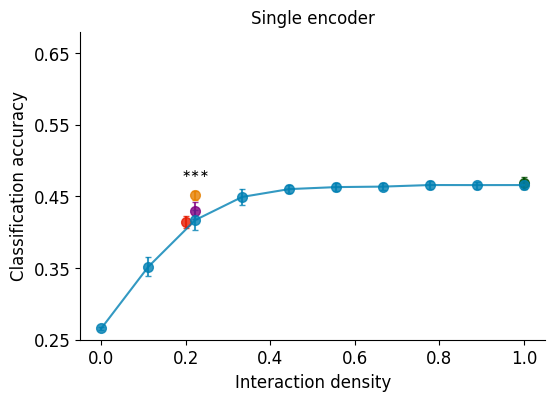

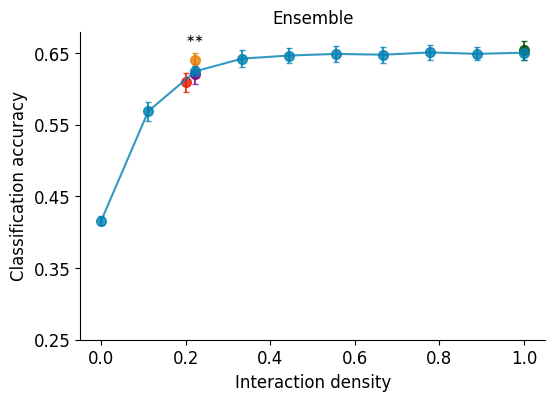

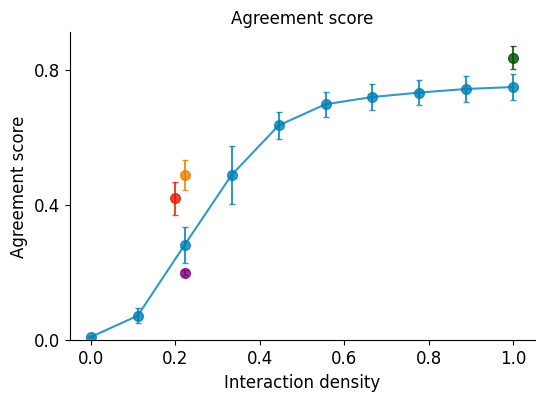

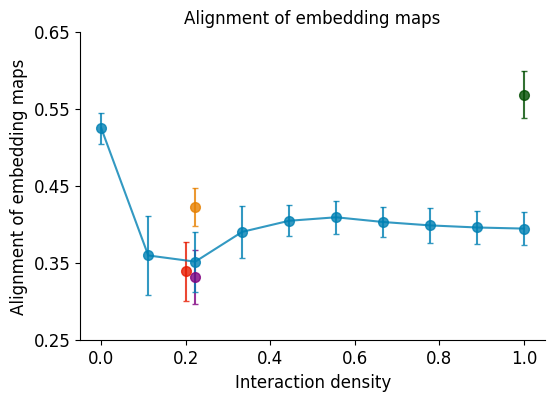

In [32]:
for task_n, (task_name, task, measure, subplot, figure) in enumerate(((EVAL_IND_LIN_NAME, EVAL_IND_LIN, False, 'b', 4), 
                                                        (EVAL_ENS_LIN_NAME, EVAL_ENS_LIN, False, 'c', 4),
                                                        (CrossPathMeasures.Acc.value, CrossPathMeasures.Acc.name, True, 'a', 's3'),
                                                        (CrossPathMeasures.Correlation.value, CrossPathMeasures.Correlation.name, True, 'b', 's3'),
                                                       )):
    common_kwargs = dict(args={}, module=Modules.VISION, seeds=SEEDS, name=task, print_missing=True, measure=measure)
    
    fig, ax = plt.subplots(figsize=(6,4))    
    plt.title(task_name, fontsize=font_size_graphs)
    
    dct = {}
    cs = {}
    
    process_metric = lambda arr: arr[..., ~np.eye(N).astype(bool)].mean(axis=-1) if measure else arr[..., -1]
    
        
    for g in [Graph.BIRING.value, Graph.FORRING.value]:
        dct[g.name] = process_metric(gather_results_over_all_args(basic_graph_format.format(name=g.name_format, d=chosen_q), **common_kwargs))
        cs[g.name] = g.int_c
    
    for k in dct:
        plot_with_CI(dct[k][None], np.array([focus_density]), axis=-1, c=cs[k], **plot_with_CI_kwargs)
        
    fc_graph = process_metric(gather_results_over_all_args(model_format_closer.format(d=chosen_q, seed="{seed}"), **common_kwargs))
    plot_with_CI(fc_graph[None], densities[-1:], axis=-1, c=Graph.FULLY_CONNECTED.value.int_c, **plot_with_CI_kwargs)
    
    
    star_res = process_metric(gather_results_over_all_args(basic_graph_format.format(name=Graph.STAR.value.name_format, d=chosen_q), **common_kwargs))
    plot_with_CI(star_res[None], np.array([Graph.STAR.value.density]), axis=-1, c=Graph.STAR.value.int_c, **plot_with_CI_kwargs)
    
    
    numedges_res = np.full((2 + NUMEDGES.size, SEEDS.size), np.nan)
    numedges_res[0] = process_metric(gather_results_over_all_args(model_format_untrained.format(d=chosen_q, seed="{seed}"), **common_kwargs))
    numedges_res[-1] = process_metric(gather_results_over_all_args(model_format_closer.format(d=chosen_q, seed="{seed}") + "_sg", **common_kwargs))
    for i, numedges in enumerate(NUMEDGES):
        numedges_res[1+i] = process_metric(gather_results_over_all_args(numedges_format.format(numedges=numedges, d=chosen_q), **common_kwargs))
    plot_with_CI(numedges_res, densities, axis=-1, c=Graph.NUMEDGES.value.int_c, **plot_with_CI_kwargs)
    dct_same_dens = {
        Graph.FORRING.value.name: dct[Graph.FORRING.value.name], 
        Graph.NUMEDGES.value.name: numedges_res[np.where(densities == focus_density)[0][0]],
        Graph.BIRING.value.name: dct[Graph.BIRING.value.name]
    }
    
    # significance plot
    from utils.plot_utils import pvalue_to_str
    sig_string = pvalue_to_str(paired_t_test(dct_same_dens[Graph.FORRING.value.name], dct_same_dens[Graph.NUMEDGES.value.name], alternative='greater'))
    if not measure: plt.text(focus_density, np.nanmean(dct_same_dens[Graph.FORRING.value.name])+0.03, sig_string, ha='center', va='center', size=8)
    
    # ticks and axes
    XLABEL_INTER_F(fontsize=font_size_graphs)
    if measure:
        plt.ylabel(task_name, fontsize=font_size_graphs)
    else:
        YLABEL_CLASS_F(fontsize=font_size_graphs)
    if not measure:
        plt.ylim(0.25, 0.68)
    else:
        if plt.ylim()[0] < 0:
            plt.ylim(0)
    
    plt.yticks(plt.yticks()[0][::2], plt.yticks()[1][::2], size=font_size_graphs)
    plt.xticks(np.linspace(0, 1, 6), size=font_size_graphs)    
    remove_spines(ax, top_right=True)
#     savefig(f"sparse_acc_{task_name}_d{d}")
    savefig(subplot, figure)

# Supplementary figure 3

see figure 4b

# Figure 5

## Figure 5a and 5b

In [33]:
mlp_fontsize=12

if REPO:
    fully_connected_format = "fc_N10_d{d}_seed{seed}_1024_512_256_out256" 
    fc_unsup_end = ""
    fc_untrained_end = "_untrained"
    fc_supervised_end = "_supervised"
else:
    fully_connected_format = "fc_nopatchenc_10_fixed_d{d}_seed{seed}_1024_512_256_out256_encperpath" 
    fc_unsup_end = "_mse_log_noreg"
    fc_untrained_end = "_untrained"
    fc_supervised_end = "_pathsup"

saved figure as figures/5/a.png
saved figure as figures/5/b.png


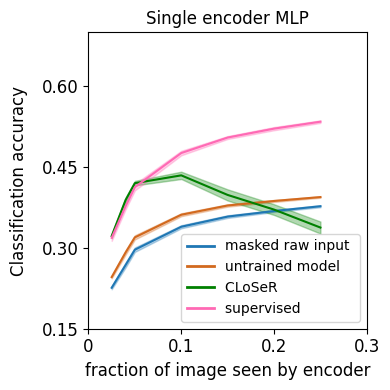

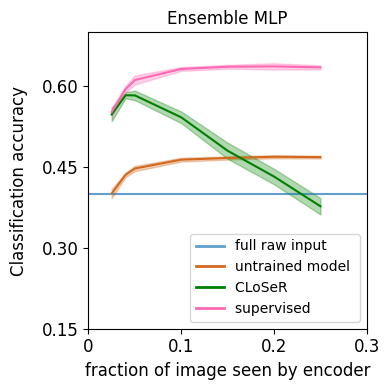

In [34]:
stop_q = np.where(np.array(EXTENDED_QS) == 0.3)[0][0]
LESS_EXTENDED_QS = np.array(EXTENDED_QS[:stop_q])
FC_SEEDS = np.arange(1,11)
for subfig, t, task_name in zip(("a", "b"), (task_ind, task_ens), (EVAL_IND_LIN_NAME,EVAL_ENS_LIN_NAME)):
    fig, ax = plt.subplots(figsize=(4,4))
    if t == task_ind: 
        plot_along_q(model_format + fc_untrained_end, module=Modules.VISION, seeds=FC_SEEDS, args=[], 
                     suptitle=False, ax=ax, qs=LESS_EXTENDED_QS, name=task_ind_imgs, fig=fig, 
                     legend=NamesAndColors.MASKED.value.name,
                     c=NamesAndColors.MASKED.value.c, print_missing=True)
    else:
        ax.axhline(full_img_baseline, label=NamesAndColors.FULL_INPUT.value.name, 
                   c=NamesAndColors.FULL_INPUT.value.get_c(), alpha=0.7)
    
    for name_and_color, end in zip([NamesAndColors.UNTRAINED, NamesAndColors.UNSUPERVISED, NamesAndColors.SUPERVISED, ], 
                                        [fc_untrained_end, fc_unsup_end, fc_supervised_end]):
        plot_along_q(fully_connected_format + end, module=Modules.VISION, seeds=FC_SEEDS, args=[], ax=ax,
                     suptitle=False, qs=LESS_EXTENDED_QS, name=t, fig=fig, 
                     legend=name_and_color.value.name, c=name_and_color.value.c, print_missing=True)
        
    Q_OVER_ACC_F()
    plt.title(task_name + " MLP", size=mlp_fontsize)
    plt.xlim(0, EXTENDED_QS[stop_q])
    plt.subplots_adjust(top=0.92)
    plt.ylabel(ax.get_ylabel(), size=mlp_fontsize, labelpad=10)
    plt.xlabel(ax.get_xlabel(), size=mlp_fontsize)
    yticks = plt.yticks()
    plt.yticks(np.arange(0.15, 0.71, 0.15), size=mlp_fontsize)
    plt.xticks(np.linspace(0, 0.3, 4), [f"{v:.1f}" if v > 0 else "0" for v in np.linspace(0, 0.3, 4)], size=mlp_fontsize)
    plt.ylim(0.15, 0.7)
    plt.tight_layout()
    legend_linewidth(ax, loc='lower right')
    savefig(subfig, 5)

## Figure 5c

saved figure as figures/5/c.png


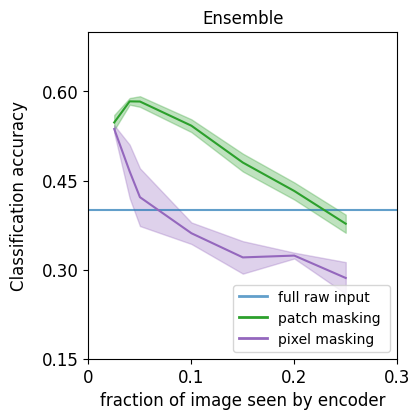

In [35]:
if REPO:
    pixels_maskings_formats = ['', '_rgb']
    fully_connected_masking_format = "fc_N10_d{{d}}_seed{{seed}}_1024_512_256_out256{masking}" 
else:
    pixels_maskings_formats = ['enc', '_rgb']
    fully_connected_masking_format = "fc_nopatch{masking}_10_fixed_d{{d}}_seed{{seed}}_1024_512_256_out256_encperpath" 



fig, ax = plt.subplots(figsize=(4,4))    
ax.axhline(full_img_baseline, label=NamesAndColors.FULL_INPUT.value.name, 
           c=NamesAndColors.FULL_INPUT.value.get_c(), alpha=0.7)
for i, (masking, name) in enumerate(zip(pixels_maskings_formats, 
                                        ['patch masking', 'pixel masking', ])):
    plot_along_q(fully_connected_masking_format.format(masking=masking) + fc_unsup_end, 
                 module=Modules.VISION, seeds=FC_SEEDS, args=[], ax=ax,
                     suptitle=False, qs=LESS_EXTENDED_QS, name=task_ens, fig=fig, legend=name, 
                 c=f"C{2*i+2}", print_missing=True)


Q_OVER_ACC_F()
plt.title(ENSEMBLE_TITLE)
plt.xlim(0, EXTENDED_QS[stop_q])
plt.ylabel(ax.get_ylabel(), size=mlp_fontsize, labelpad=10)
plt.xlabel(ax.get_xlabel(), size=mlp_fontsize)
plt.yticks(np.arange(0.15, 0.71, 0.15), size=mlp_fontsize)
plt.xticks(np.linspace(0, 0.3, 4), [f"{v:.1f}" if v > 0 else "0" for v in np.linspace(0, 0.3, 4)], size=mlp_fontsize)
plt.ylim(0.15, 0.7)
legend_linewidth(ax, loc='lower right')
savefig("c", 5)

# Figure 6

## Figure 6b and supplementary figure 5

In [36]:
NEUR_SEEDS = np.arange(1,31)

In [37]:
if REPO:
    ses_and_areas = [12, 15, 17, 18]
    neur_model_format = "fc_10_seed{{seed}}_ses{ses}_areas"
    LPL_ending = "_LPL_reg_5e-6"
    TCLoSeR_ending = "_tcloser_reg_5e-6"
    untrained_ending = "_untrained"
else:
    ses_and_areas = [
        "12_LP_VISrl_CA1_VISam_PO_LGd_VISp_SUB_Eth_SGN", 
        "15_VISam_VISp_VISpm_ProS_VISrl_CA1_LGd_VISal_VISl_MGv",
        "17_LP_CA1_VISp_PO_VISam_VISl_VISal_SGN_SUB_VISrl",
        "18_CA1_VISp_VISam_LP_VISli_VISal_ProS_VISrl_LGd_MB", 
    ]
    neur_model_format = "paths_10_seed{{seed}}_ses{ses}_mod_frames2_bps1_MLP"
    LPL_ending = "_LPL_reg_5e-6"
    TCLoSeR_ending = "_var_cov_crosscont2_reg_5e-6"
    untrained_ending = ""

In [38]:
from enum import Enum
crosscont_w = 2

class NeuNameAndColors(Enum):
    UNTRAINED = NameAndColor(NamesAndColors.UNTRAINED.value.name, color=NamesAndColors.UNTRAINED.value.c, 
                             ending=untrained_ending, inp=False, pred=False)
    MASKED = NameAndColor(NamesAndColors.MASKED.value.name, color=NamesAndColors.MASKED.value.c, 
                          ending=untrained_ending, inp=True, pred=False)
    LPL = NameAndColor("LPL", c='brown', ending=LPL_ending, inp=False, pred=False)
    TCLoSeR = NameAndColor("T" + NamesAndColors.UNSUPERVISED.value.name, 
                        c=NamesAndColors.UNSUPERVISED.value.c, ending=TCLoSeR_ending, inp=False, pred=False)

In [39]:
from neuronal.utils.data import Labels as NeurLabels

input_txt = 'input'
task_ens_neur = 'linear'

lbl_neur = NeurLabels.STIMULUS.value.name
full_name_task_neur_ind = '_'.join([lbl_neur, task_ind])
full_name_task_neur_ens = '_'.join([lbl_neur, task_ens_neur])
full_name_task_neur_ind_inp = '_'.join([lbl_neur, input_txt, task_ind])
full_name_task_neur_ens_inp = '_'.join([lbl_neur, input_txt, task_ens_neur])

In [40]:
class Metric:
    def __init__(self, measure, task_name, task, task_inp):
        self.measure = measure
        self.task_name = task_name
        self.task = task
        self.task_inp = task_inp
        
class Metrics(Enum):
    MEAN_IND = Metric(False, EVAL_IND_LIN_NAME, full_name_task_neur_ind, full_name_task_neur_ind_inp)
    ENS = Metric(False, EVAL_ENS_LIN_NAME, full_name_task_neur_ens, full_name_task_neur_ens_inp)    
    IND = lambda i: Metric(False, f"Encoder {i} accuracy", f"stimulus_pathway{i}_linear", f"stimulus_input_pathway{i}_linear")
    ACC = Metric(True, CrossPathMeasures.Acc.value, CrossPathMeasures.Acc.name, None)
    CORRELATION = Metric(True, CrossPathMeasures.Correlation.value, CrossPathMeasures.Correlation.name, None)    

In [41]:
import math
def lines_in_name(n):
    if " " in n:
        splitted = n.split(" ")
        mid = int(len(splitted)//2)
        new_name = " ".join([splitted[i] if i not in (mid-1, mid) else (splitted[i] + "\n" + splitted[i+1]) for i in range(len(splitted)) if i != mid])
        return new_name
    return n

def lines_in_keys(dct):
    return {lines_in_name(k):v for k,v in dct.items()}

In [42]:
from vision.evaluate import EVAL_IND_LIN_NAME, EVAL_ENS_LIN_NAME
def violinplot_model(ses, metrics=[Metrics.MEAN_IND.value, Metrics.ENS.value], 
                     anchor=NeuNameAndColors.TCLoSeR.value.name, 
                     ncs=[NeuNameAndColors.UNTRAINED.value, NeuNameAndColors.MASKED.value, 
                          NeuNameAndColors.LPL.value, NeuNameAndColors.TCLoSeR.value],
                     print_missing=True, seeds=NEUR_SEEDS, plot=True, fontsize=10,
                     significance_dist=0.0075, figsize=(7,5), sharey=True, add_text=True, chance=2/3, rotation=70, **kwargs):
    all_dcts = {}
    rows, cols = calculate_square_rows_cols(len(metrics))
    if plot: fig, axs = plt.subplots(rows, cols, figsize=figsize, sharey=sharey)
    for i, (ax, metric) in enumerate(zip(axs, metrics)):
        measure, task_name, task, task_inp = metric.measure, metric.task_name, metric.task, metric.task_inp
        basic = neur_model_format.format(ses=ses)
        
        def gather(base, nc:NeuNameAndColors):
            res = []
            for seed in seeds:
                if measure and nc.inp:
                    res.append(np.nan)
                else:
                    cur_name = base.format(seed=seed) + nc.ending
                    cur_dct = (Modules.NEURONAL.load_measures_json if measure else Modules.NEURONAL.load_evaluation_json)(cur_name)
                    
                    cur_task = task_inp if nc.inp else task
                    current_task_key = task_inp if nc.inp else task
                       
                    if cur_dct is None or current_task_key not in cur_dct:
                        if print_missing:
                            print(f"couldn't load {current_task_key} from {cur_name}")
                        res.append(np.nan)
                    else:
                        seed_res = cur_dct[current_task_key]
                        if measure:
                            seed_res = seed_res[np.eye(len(seed_res)) == 0].mean()
                        else:
                            seed_res = seed_res[-1]
                        res.append(seed_res)   
            return np.stack(res)
        dct = {nc.name: gather(basic, nc) for i, nc in enumerate(ncs)}
        
        if plot:
            cs = {nc.name: nc.c for i, nc in enumerate(ncs)}
            ordering = list(dct.keys())
            
            from utils.plot_utils import dct_to_multiviolin
            dct_to_multiviolin(lines_in_keys(dct), fig=fig, rotation=rotation, c=lines_in_keys(cs), ax=ax)
            
            if not isinstance(anchor, list):
                anchor = [anchor]
            for anc in anchor:
                plot_significance_anchor(lines_in_keys(dct), lines_in_name(anc), ax=ax,
                                         test=ind_permutation_test, 
                                         significance_dist=significance_dist, **kwargs)
            if not i: ax.set_ylabel(task if measure else f"{lbl_neur} decoding accuracy")
            ax.set_title(task_name, pad=20, size=fontsize*1.1)
            if chance:
                ax.axhline(chance, linestyle=':', c=NamesAndColors.CHANCE.value.c, label=NamesAndColors.CHANCE.value.name)
            remove_spines(ax, top_right=True)
            ylim = axs[0].get_ylim()
            ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), size=fontsize)
    axs[0].set_ylabel(ax.get_ylabel(), size=fontsize)
    ticks = np.arange(ylim[0]-(ylim[0] % 0.05), ylim[1] + 0.05 - (ylim[0] % 0.05), 0.1)
    axs[0].set_yticks(ticks, [f"{v:.2f}" for v in ticks], size=fontsize)
    if plot: plt.tight_layout(h_pad=5)


saved figure as figures/s5/0.png


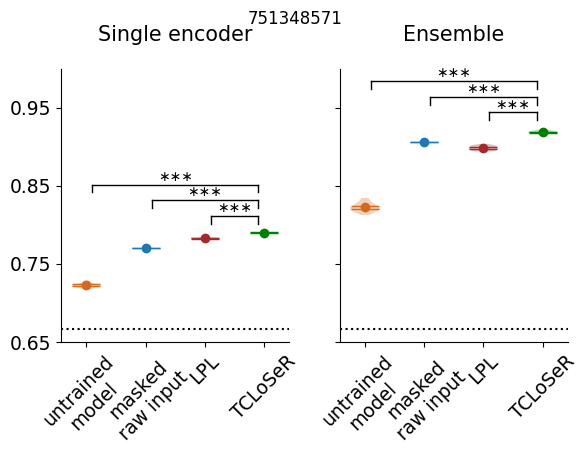

saved figure as figures/6/bc.png
saved figure as figures/s5/1.png


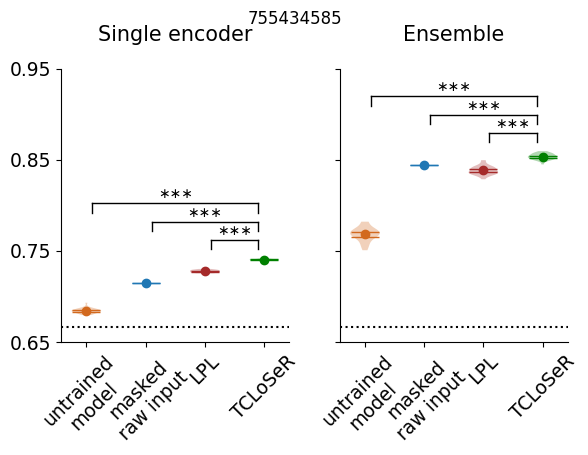

saved figure as figures/s5/2.png


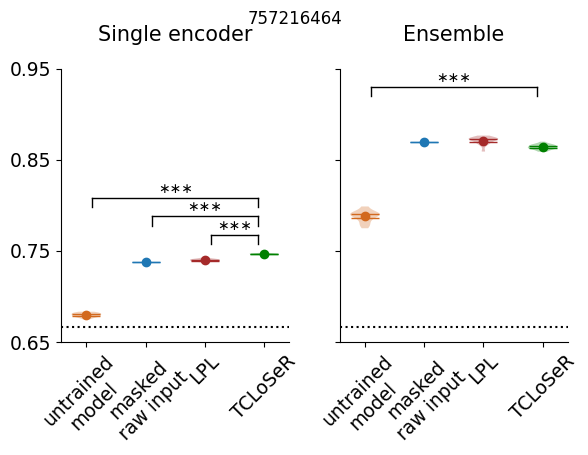

saved figure as figures/s5/3.png


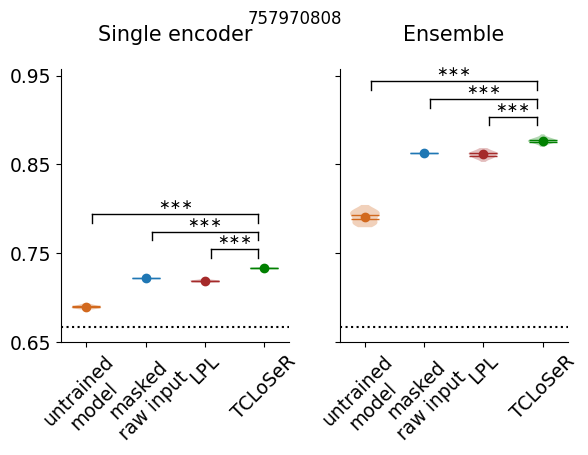

In [43]:
from neuronal.utils.consts import SESSIONS
ADD_TEXT = False
for i, k in enumerate(ses_and_areas):
    if '17' in k or '12' in k:
        sign_kwargs = dict(significance_dist=0.02, dist=0.01, dist_from_edges=0.1,)
    else:
        sign_kwargs = dict(significance_dist=0.02, dist=0.01, dist_from_edges=0.1,)
    
    violinplot_model(k, print_missing=True, **sign_kwargs, add_text=ADD_TEXT, figsize=(6, 4.5), 
                     ncs=[nc.value for nc in NeuNameAndColors], rotation=45, plot=True, fontsize=13.5)
    ses_num = int(k.split("_")[0])
    ses_id = SESSIONS[ses_num]
    plt.suptitle(f"{ses_id}", y=1)  # The session number was added in drawio, but we keep it like that in the repo notebook
    if k.startswith("15"):
        savefig("bc", 6)
    savefig(str(i), "s5")   
    plt.show()

# Supplementary figure 5

See figure 6b

# Supplementary figure 6

In [44]:
def sec2hour(n):
    return n / 3600

def sec2mins(n):
    return n / 60

In [45]:
def get_elapsed_time(model, module=Modules.VISION):
    fn = os.path.join(module.value, "models", model, "runtime.txt")
    if os.path.exists(fn):
        with open(fn) as f:
            runtime = int(f.readlines()[0])
    else:
        print(model, "runtime doesn't exist:", fn)
        runtime = np.nan
    return runtime

In [46]:
def finalize():
    plt.ylabel("GPU hours")
    plt.legend()
    plt.tight_layout()

## Supplementary figure 6a

In [47]:
elapsed_time = np.array([[get_elapsed_time(model_format_N_closer.format(N=N, seed=seed, d=q)) for seed in SEEDS] for q in EXTENDED_QS])
elapsed_time_supervised = np.array([[get_elapsed_time(model_format_sup.format(seed=seed, d=q)) for seed in SEEDS] for q in EXTENDED_QS])

saved figure as figures/s6/a.png


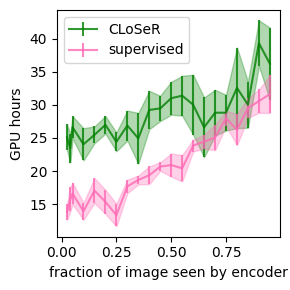

In [48]:
from utils.plot_utils import plot_with_CI, XLABEL_FRAC_F
plt.figure(figsize=(3,3))
plot_with_CI(sec2hour(elapsed_time), np.array(EXTENDED_QS), axis=-1, c=NamesAndColors.UNSUPERVISED.value.c, label=NamesAndColors.UNSUPERVISED.value)
plot_with_CI(sec2hour(elapsed_time_supervised), np.array(EXTENDED_QS), axis=-1, c=NamesAndColors.SUPERVISED.value.c, label=NamesAndColors.SUPERVISED.value)
XLABEL_FRAC_F()
finalize()
savefig("a", "s6")

## Supplementary figure 6b

In [49]:
elapsed_time_N = np.array([[get_elapsed_time(model_format_N_closer.format(N=n, seed=seed, d=chosen_q)) 
                            for seed in SEEDS] if n != N else elapsed_time[EXTENDED_QS.index(chosen_q)] 
                           for n in NS])

saved figure as figures/s6/b.png


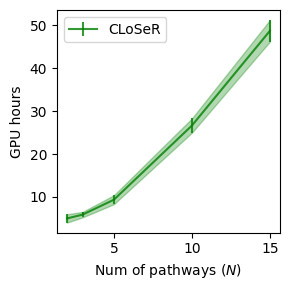

In [50]:
from utils.plot_utils import plot_with_CI, XLABEL_FRAC_F
plt.figure(figsize=(3,3))
plot_with_CI(sec2hour(elapsed_time_N), np.array(NS), axis=-1, c=NamesAndColors.UNSUPERVISED.value.c, 
             label=NamesAndColors.UNSUPERVISED.value)
plt.xlabel(r"Num of pathways ($N$)")
finalize()
savefig("b", "s6")

## Supplementary figure 6c

In [51]:
elapsed_time_fc = np.array([[get_elapsed_time(fully_connected_format.format(d=q, seed=seed) + fc_unsup_end) 
                             for seed in SEEDS] 
                         for q in LESS_EXTENDED_QS])
elapsed_time_fc_pixel = np.array([[get_elapsed_time(fully_connected_masking_format.format(masking=pixels_maskings_formats[1]).format(d=q, seed=seed) + fc_unsup_end) 
                                   for seed in SEEDS] 
                         for q in LESS_EXTENDED_QS])
elapsed_time_fc_supervised = np.array([[get_elapsed_time(fully_connected_format.format(d=q, seed=seed) + fc_supervised_end) for seed in SEEDS] 
                         for q in LESS_EXTENDED_QS])

saved figure as figures/s6/c.png


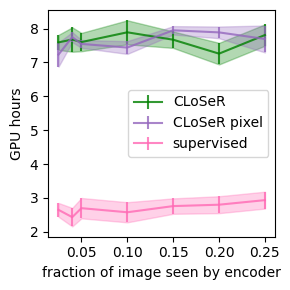

In [52]:
from utils.plot_utils import plot_with_CI, XLABEL_FRAC_F
plt.figure(figsize=(3,3))
plot_with_CI(sec2hour(elapsed_time_fc), np.array(LESS_EXTENDED_QS), axis=-1, c=NamesAndColors.UNSUPERVISED.value.c, label=NamesAndColors.UNSUPERVISED.value)
plot_with_CI(sec2hour(elapsed_time_fc_pixel), np.array(LESS_EXTENDED_QS), axis=-1, c="C4", label=NamesAndColors.UNSUPERVISED.value.name + " pixel")
plot_with_CI(sec2hour(elapsed_time_fc_supervised), np.array(LESS_EXTENDED_QS), axis=-1, c=NamesAndColors.SUPERVISED.value.c, label=NamesAndColors.SUPERVISED.value)
XLABEL_FRAC_F()
finalize()
savefig("c", "s6")

## Neuronal runtime

In [53]:
from tqdm import tqdm as counter
elapsed_time_fc_LPL = np.array([[get_elapsed_time(neur_model_format.format(ses=ses).format(seed=seed) + NeuNameAndColors.LPL.value.ending, 
                                                  module=Modules.NEURONAL) for seed in SEEDS] 
                         for ses in ses_and_areas])
elapsed_time_fc_TCLoSeR = np.array([[get_elapsed_time(neur_model_format.format(ses=ses).format(seed=seed) + NeuNameAndColors.TCLoSeR.value.ending, 
                                                      module=Modules.NEURONAL) for seed in SEEDS] 
                         for ses in ses_and_areas])

Text(0, 0.5, 'GPU minutes')

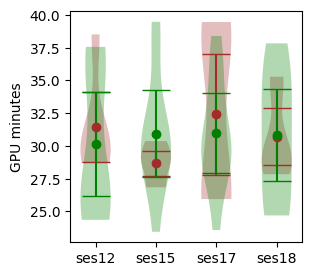

In [54]:
fig = plt.figure(figsize=(3,3))
dct_to_multiviolin({f"ses{ses.split('_')[0]}": sec2mins(elapsed_time_fc_LPL[i]) for i, ses in enumerate(ses_and_areas)}, 
                   c=NeuNameAndColors.LPL.value.c, fig=fig)
dct_to_multiviolin({f"ses{ses.split('_')[0]}": sec2mins(elapsed_time_fc_TCLoSeR[i]) for i, ses in enumerate(ses_and_areas)}, fig=fig, 
                    c=NeuNameAndColors.TCLoSeR.value.c)
plt.ylabel("GPU minutes")

## Sparse runtime

Although it is sparser in theory, the actual implementation doesn't take it into account, and therefore isn't faster

In [55]:
elapsed_time_numedge = np.array([[get_elapsed_time(numedges_format.format(d=chosen_q, numedges=numedges).format(seed=seed)) 
                                 for seed in SEEDS] 
                                for numedges in NUMEDGES])
elapsed_time_all_sg = np.array([get_elapsed_time(model_format_closer.format(seed=seed, d=chosen_q) + "_sg") for seed in SEEDS])[None]
elapsed_time_numedge_all = np.concatenate([elapsed_time_numedge, elapsed_time_all_sg], axis=0)
elapsed_time_bidirectional = np.array([get_elapsed_time(basic_graph_format.format(name=Graph.BIRING.value.name_format, d=chosen_q).format(seed=seed)) for seed in SEEDS])[None]
elapsed_time_directional = np.array([get_elapsed_time(basic_graph_format.format(name=Graph.FORRING.value.name_format, d=chosen_q).format(seed=seed)) for seed in SEEDS])[None]
elapsed_time_star = np.array([get_elapsed_time(basic_graph_format.format(name=Graph.STAR.value.name_format, d=chosen_q).format(seed=seed)) for seed in SEEDS])[None]

In [56]:
elapsed_time_sparse_all = np.concatenate([elapsed_time_numedge_all, elapsed_time_bidirectional, elapsed_time_directional, elapsed_time_star], axis=0)

/tmp/ipykernel_2182575/1481906600.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(20, sec2hour(elapsed_time_numedge_all)[1].mean(), c=Graph.NUMEDGES.value.int_c)
/tmp/ipykernel_2182575/1481906600.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(20, sec2hour(elapsed_time_bidirectional).mean(), c=Graph.BIRING.value.int_c)
/tmp/ipykernel_2182575/1481906600.py:8: UserWarning: *c* argument looks lik

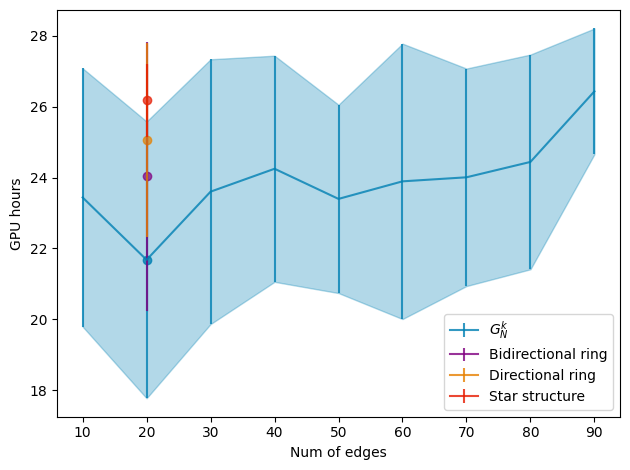

In [57]:
from utils.plot_utils import plot_with_CI, XLABEL_FRAC_F
plot_with_CI(sec2hour(elapsed_time_numedge_all), np.concatenate([NUMEDGES, [90]]), axis=-1, label=Graph.NUMEDGES.value.name, c=Graph.NUMEDGES.value.int_c)
plot_with_CI(sec2hour(elapsed_time_bidirectional), np.array([20]), axis=-1, label=Graph.BIRING.value.name, c=Graph.BIRING.value.int_c)
plot_with_CI(sec2hour(elapsed_time_directional), np.array([20]), axis=-1, label=Graph.FORRING.value.name, c=Graph.FORRING.value.int_c)
plot_with_CI(sec2hour(elapsed_time_star), np.array([20]), axis=-1, label=Graph.STAR.value.name, c=Graph.STAR.value.int_c)
plt.scatter(20, sec2hour(elapsed_time_numedge_all)[1].mean(), c=Graph.NUMEDGES.value.int_c)
plt.scatter(20, sec2hour(elapsed_time_bidirectional).mean(), c=Graph.BIRING.value.int_c)
plt.scatter(20, sec2hour(elapsed_time_directional).mean(), c=Graph.FORRING.value.int_c)
plt.scatter(20, sec2hour(elapsed_time_star).mean(), c=Graph.STAR.value.int_c)

plt.xlabel(r"Num of edges")
finalize()

## Total runtime

In [58]:
sec2hour(sum([np.nansum(arr) for arr in [elapsed_time, elapsed_time_supervised,
                                         elapsed_time_N[:NS.tolist().index(N)], 
                                         elapsed_time_N[NS.tolist().index(N)+1:], 
                                         elapsed_time_sparse_all, 
                                         elapsed_time_fc, elapsed_time_fc_pixel, elapsed_time_fc_supervised,
                                         elapsed_time_fc_LPL, elapsed_time_fc_TCLoSeR,
                                        ]])) /24

639.0172916666667